# Opis
W pierwszym kroku przeanalizowano dane i dokonano selekcji zmiennych. Przy pomocy algorytmu <em>mutual information</em>, zmniejszajono ich liczbę z 57 do 47.

Następnie przy pomocy metody <em>grid search</em> sprawdzono pięć klasyfikatorów:
- SVM
- regresja logistyczna
- drzewo losowe
- las losowy
- naiwny Bayes

Najlepszy wynik uzyskał klasyfikator **las losowy** osiągając dokładność **66,68%** <br/>
Podsumowanie wyników:
- las losowy: **66,68%**
- SVM: **65.57%**
- regresja logistyczna: **64.74%**
- drzewo losowe: **63.56%**
- naiwny Bayes: **59.66%**



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel, mutual_info_classif


In [2]:
df = pd.read_csv('data/set.csv')
df['class'] = df.apply(lambda row: 'HIGH' if row['shares']>=1400 else 'LOW', axis=1)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,class
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,LOW
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,LOW
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,HIGH
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,LOW
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,LOW


In [3]:
X = df.drop(['shares', 'class','url','timedelta'], axis=1)
y = df['class']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Analiza danych

## Rozkład klas

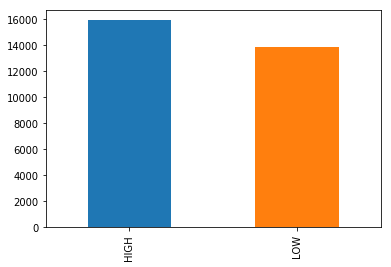

In [5]:
y_train.value_counts().plot('bar')

## Analiza PCA

In [6]:
an_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=58))
])
projected = an_pipe.fit_transform(X_train)
pca = an_pipe.named_steps['pca']

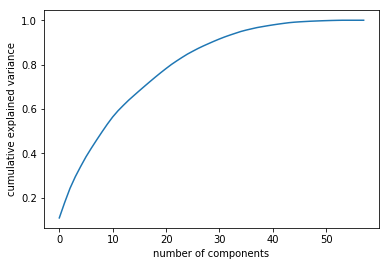

In [7]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

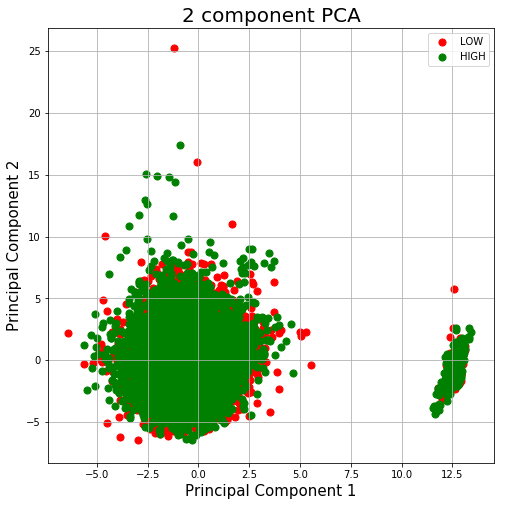

In [8]:
y_train_pca =y_train.reset_index()
pca_df = pd.DataFrame(data = projected[:,:2], columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([pca_df, y_train_pca['class']], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['LOW', 'HIGH']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## Analiza cech

In [9]:
train_df = pd.concat([X_train, y_train], axis = 1)
train_df['class'] = train_df.apply(lambda row: 1. if row['class']=='HIGH' else 0., axis=1)
corr_df=train_df.corr(method ='pearson')
correlations = corr_df['class'].drop(labels=['class']).values

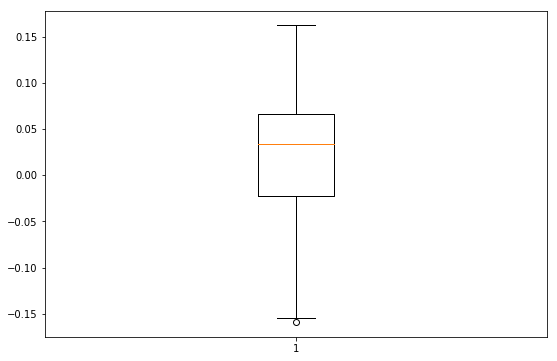

In [10]:
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(correlations)

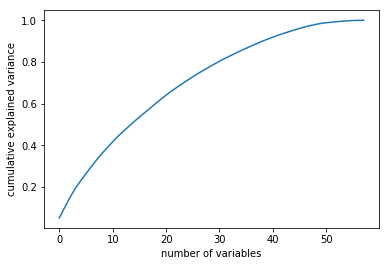

In [11]:
var = np.sort(np.abs(correlations))[::-1]
var = var/var.sum()
plt.plot(np.cumsum(var))
plt.xlabel('number of variables')
plt.ylabel('cumulative explained variance');

## Mutual information

In [12]:
MI = mutual_info_classif(X_train, y_train,n_neighbors=4, random_state=0)

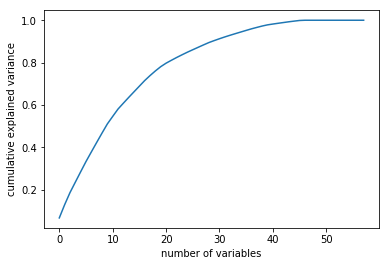

In [13]:
mi = np.sort(np.abs(MI))[::-1]
mi = mi/mi.sum()
plt.plot(np.cumsum(mi))
plt.xlabel('number of variables')
plt.ylabel('cumulative explained variance');

In [14]:
indexes_to_drop = []
for i, val in enumerate(MI):
    if val==0:
        indexes_to_drop.append(i)
indexes_to_drop
#indexes_to_drop = [0, 1, 3, 8, 13, 31, 32, 33, 35, 51, 53]

[0, 1, 3, 8, 13, 31, 32, 33, 35, 51, 53]

## Usunięcie zmiennych na podstawie MI

In [15]:
X_train = X_train.drop(X_train.columns[indexes_to_drop],axis=1)
X_test = X_test.drop(X_test.columns[indexes_to_drop],axis=1)

# Statystyki modelu

In [16]:
def best_model_metrics(model, X_test, y_test):
    acc = model.score(X_test, y_test)
    print("acc: {:.2f}%".format(acc*100))
    
    if hasattr(model, "decision_function"):
        preds = model.decision_function(X_test)
    else:
        preds = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds, pos_label='LOW')
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))    

# SVM

In [40]:
svc_params = [{
    'C': np.logspace(-4, 4, 5),
    'gamma': [1e-3, 1e-4,'scale', 'auto'],
    'kernel': ['rbf']
}]

svc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    #('svc', SVC(kernel='linear'))
    ('grid', GridSearchCV(estimator=SVC(), param_grid=svc_params, n_jobs=-1, cv=2,verbose=1))
])

svc_pipe.fit(X_train, y_train)


Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 41.3min finished


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('grid', GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1))])

In [41]:
print(svc_pipe.named_steps['grid'].best_estimator_)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


acc: 65.57%


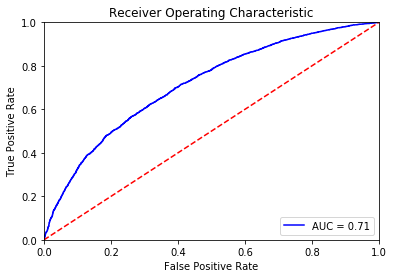

              precision    recall  f1-score   support

        HIGH       0.66      0.71      0.69      5248
         LOW       0.65      0.59      0.62      4663

   micro avg       0.66      0.66      0.66      9911
   macro avg       0.65      0.65      0.65      9911
weighted avg       0.66      0.66      0.65      9911



In [42]:
best_model_metrics(svc_pipe, X_test, y_test)

# Regresja logistyczna

In [103]:
logit_params = [{
            'C': np.logspace(-4, 4, 20),
            'solver':['lbfgs', 'liblinear'],
            'class_weight':[None,'balanced']
        }]
logit_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('grid', GridSearchCV(estimator=LogisticRegression(), param_grid=logit_params, n_jobs=-1, cv=3, verbose=1))
])

logit_pipe.fit(X_train, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   51.9s finished


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('grid', GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
   ...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1))])

In [104]:
print(logit_pipe.named_steps['grid'].best_estimator_)

LogisticRegression(C=0.03359818286283781, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)


acc: 64.74%


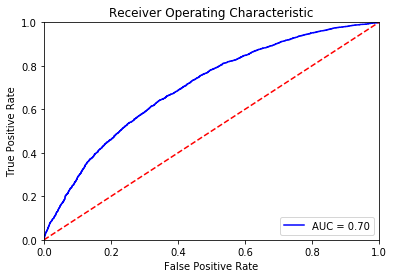

              precision    recall  f1-score   support

        HIGH       0.66      0.69      0.68      5248
         LOW       0.63      0.60      0.61      4663

   micro avg       0.65      0.65      0.65      9911
   macro avg       0.65      0.64      0.64      9911
weighted avg       0.65      0.65      0.65      9911



In [105]:
best_model_metrics(logit_pipe, X_test, y_test)

# Drzewo losowe

In [27]:
tree_params = [{
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 10, 20, None],
        'min_samples_split':[2, 5, 10] 
    }]
tree_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('grid', GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=tree_params, n_jobs=-1, cv=3, verbose=1))
])

tree_pipe.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   29.9s finished


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('grid', GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_i...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1))])

In [28]:
print(tree_pipe.named_steps['grid'].best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


acc: 63.56%


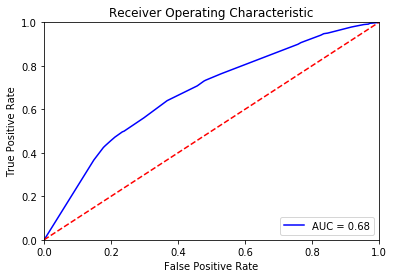

              precision    recall  f1-score   support

        HIGH       0.64      0.70      0.67      5248
         LOW       0.63      0.56      0.59      4663

   micro avg       0.64      0.64      0.64      9911
   macro avg       0.63      0.63      0.63      9911
weighted avg       0.63      0.64      0.63      9911



In [29]:
best_model_metrics(tree_pipe, X_test, y_test)

# Las Losowy

In [32]:
forest_params = [{
        'max_depth': [1, 4, 5, 10],
        'min_samples_split': [2, 5],
        'n_estimators': [100, 200, 300, 400, 800, 1000]
    }]

forest_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    #('forest', RandomForestClassifier())
    ('grid', GridSearchCV(estimator=RandomForestClassifier(), param_grid=forest_params, n_jobs=-1, cv=2, verbose=1))
])

forest_pipe.fit(X_train, y_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  7.9min finished


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('grid', GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1))])

In [33]:
print(forest_pipe.named_steps['grid'].best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


acc: 66.68%


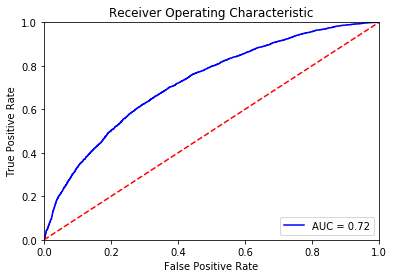

              precision    recall  f1-score   support

        HIGH       0.67      0.74      0.70      5248
         LOW       0.67      0.58      0.62      4663

   micro avg       0.67      0.67      0.67      9911
   macro avg       0.67      0.66      0.66      9911
weighted avg       0.67      0.67      0.66      9911



In [34]:
best_model_metrics(forest_pipe, X_test, y_test)

# Klasyfikator Naiwny Bayesa

In [35]:
nb_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('nb', GaussianNB())
])

nb_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('nb', GaussianNB(priors=None, var_smoothing=1e-09))])

acc: 59.66%


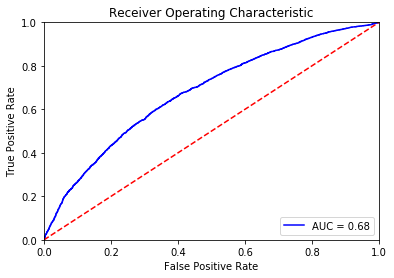

              precision    recall  f1-score   support

        HIGH       0.70      0.42      0.52      5248
         LOW       0.55      0.80      0.65      4663

   micro avg       0.60      0.60      0.60      9911
   macro avg       0.62      0.61      0.59      9911
weighted avg       0.63      0.60      0.58      9911



In [36]:
best_model_metrics(nb_pipe, X_test, y_test)